In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
code_path = "../src/"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [3]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset(Float32[0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [4]:
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [12]:
# set problem dimensions
indim = size(X,1)
hiddendim = 4
latentdim = 2
nlayers = 3

# model constructor parameters
esize = [indim; hiddendim; hiddendim; latentdim]; # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim]; # decoder architecture
L = 30 # batchsize
threshold = 0 # classification threshold, is recomputed when calling fit!
contamination = size(Y[Y.==1],1)/size(Y,1) # to set the decision threshold
iterations = 5000
cbit = 1000 # when callback is printed
verbfit = true 
activation = Flux.relu
rdelta = 0.002 # reconstruction error threshold when training is stopped
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.history
eta = 0.0001

0.0001

In [13]:
# model might have to be restarted if loss is > 0.01
model = AEmodel(esize, dsize, L, threshold, contamination,
    iterations, cbit, verbfit, activation = activation, rdelta = rdelta, 
    tracked = tracked, eta = eta)

AnomalyDetection.fit!(model, nX)
AnomalyDetection.setthreshold!(model, X)
AnomalyDetection.evalloss(model, nX)

loss: 0.28125814

loss: 0.03170499

loss: 0.008776165

loss: 0.0053964513

loss: 0.004071783

loss: 0.005108574



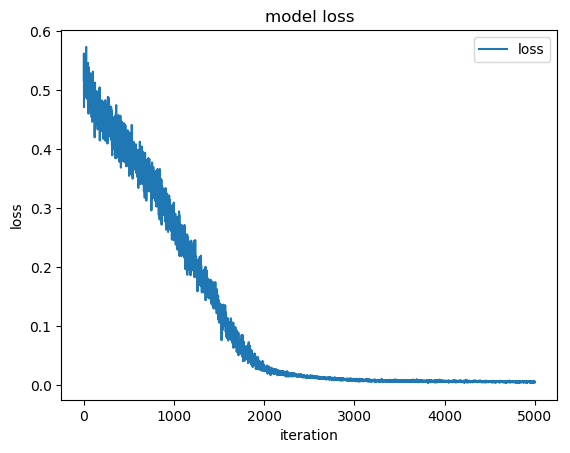

In [14]:
plot(model)
show()

In [15]:
model(nX)

Tracked 2×90 Array{Float32,2}:
 0.78923   0.788373  0.792137  0.797162  …  0.0319854  0.0403622  0.0448539
 0.732631  0.735245  0.732849  0.736644     0.971637   0.973264   0.963507 

In [16]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [18]:
model(X)

Tracked 2×103 Array{Float32,2}:
 0.78923   0.788373  0.792137  0.797162  …  -0.0171207  0.159485  0.00724068
 0.732631  0.735245  0.732849  0.736644      1.13181    0.851866  1.01302   

In [19]:
X

2×103 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  -0.00703644  0.252366  -0.216809
 0.821998  0.834235  0.826129  0.848182      1.6113      0.714171   1.09756 

In [20]:
# predict labels
yhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 0
 1

In [21]:
# training data = testing data
# this outputs labels
tryhat, tsthat, _, _ = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 88
  fp = 2
  fn = 2
precision: 0.8461538461538461
f1score: 0.8461538461538461
recall: 0.8461538461538461
false positive rate: 0.022222222222222223
equal error rate: 0.08803418803418804

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 88
  fp = 2
  fn = 2
precision: 0.8461538461538461
f1score: 0.8461538461538461
recall: 0.8461538461538461
false positive rate: 0.022222222222222223
equal error rate: 0.08803418803418804


In [22]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

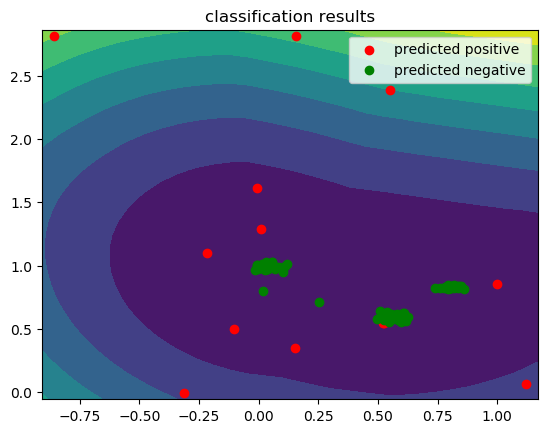

In [24]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

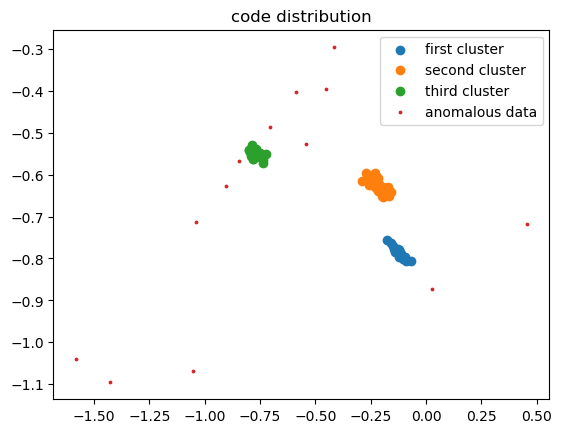

In [27]:
# what are the codes?
z1 = model.ae.encoder(X[:,1:30]).data
z2 = model.ae.encoder(X[:,31:60]).data
z3 = model.ae.encoder(X[:,61:90]).data
za = model.ae.encoder(X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

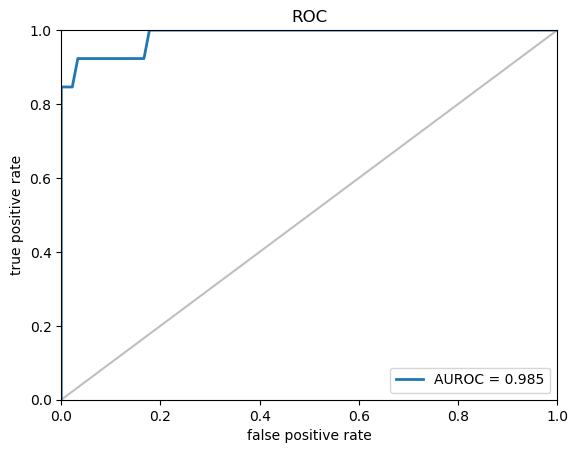

In [29]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()